In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

In [36]:
path_to_image_buoy1 = 'C:\\Users\\shant\\Underwater_Color_Segmentation_GMM_EM_Algorithm\\data\\buoy1\\train\\buoy156.png'
path_to_image_buoy2 = 'C:\\Users\\shant\\Underwater_Color_Segmentation_GMM_EM_Algorithm\\data\\buoy2\\train\\buoy108.png'
path_to_image_buoy3 = 'C:\\Users\\shant\\Underwater_Color_Segmentation_GMM_EM_Algorithm\\data\\buoy3\\train\\buoy28.png'
img1 = cv2.imread(path_to_image_buoy1)
img2 = cv2.imread(path_to_image_buoy2)
img3 = cv2.imread(path_to_image_buoy3)
cv2.imshow('img1',img1)

cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

mu:9.765625 sigma:19.870275497436523
mu:9.765625 sigma:26.297571182250977
mu:9.765625 sigma:10.711766242980957


c:\users\shant\anaconda3\envs\env\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
c:\users\shant\anaconda3\envs\env\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


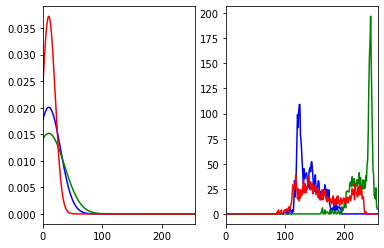

In [40]:
# Compute the average colour histogram for each of the RGB Colour channels
from scipy.stats import norm

def fit_gaussian(image):
    
    color = ('b' , 'g' , 'r') # The number of color channels
    
    for i, col in enumerate(color):
        
        # Calculate the histogram for the Red Green and Blue color channel
        # If input is grayscale the channels = [0] but for color image the channels can be [0], [1], [2]
        histr = cv2.calcHist([image],[i],None,[256],[0,256])

        (mu , sigma) = norm.fit(histr) # Maximum likelihood estimate
        bins = np.linspace(0,255,256)
        print(f'mu:{mu} sigma:{sigma}')
        plt.subplot(1,2,1)
        plt.plot(bins, norm.pdf(bins,mu,(sigma)),color=col); plt.xlim([0,256])
        plt.subplot(1,2,2)
        plt.plot(histr,color = col); plt.xlim([0,256])
    plt.show()
    
fit_gaussian(img3)

In [ ]:
# Expectation Maximization Technique

def gaussian(x, mean, covariance, dimension):
    
    determinant_covariance = np.linalg.det(covariance)
    determinant_covariance_root = np.sqrt(determinant_covariance)
    covariance_inverse = np.linalg.inv(covariance)
    gaussian_pi_coeff = 1 / np.power((2*np.pi), (dimension/2))
    data_mean_diff = (x - mean)
    data_mean_diff_transpose = (x-mean).T
    
    return (gaussian_pi_coeff)*(determinant_covariance_root)*np.exp(-0.5*np.matmul(np.matmul(data_mean_diff_transpose,covariance_inverse),data_mean_diff))
    
def gaussian_expectation(mixture_coefficients, gaussian_mean, gaussian_covariance, dimension, k,input_data):
    
    "X: The input samples to the gaussian mixture"
    "mixture_coefficients: Used when there are several gaussians. Is basically the prior"
    "gaussian_mean: mean of the gaussian distribution"
    "gaussian_covariance: covariance matrix of the gaussian distribution"
    "K: Number of clusters"
    "data_probability: List to store the Probabilities of the ith Datapoint coming from the Kth Gaussian Distribution"
    
    
    
def gaussian_maximization():
    